## Metadata

Preprocess cranberry bogs to remove unwanted artifacts and aggregate by proximity

Author: Adrian Wiegman

Date Modified: 10/31/2023

Creates a layer of cranberry bog polygons from raw input data

## Main Program

In [14]:
# iphython options
# delete variables in workspace
%reset -f
#places plots inline
%matplotlib inline
#automatically reloads modules if they are changed
%load_ext autoreload 
%autoreload 2
# this codeblock sets up the environment from jupyter notebooks
setup_notebook = "C:/Users/Adrian.Wiegman/Documents/GitHub/Wiegman_USDA_ARS/Cran_Q_C/2_gis/scripts/_Setup.ipynb"
%run $setup_notebook # magic command to run the notebook 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
***
loading python modules...

  `module_list` contains names of all loaded modules

...module loading complete

***
loading user defined functions...

type `fn_`+TAB to for autocomplete suggestions

 the object `def_list` contains user defined function names:
   fn_get_info
   fn_arcgis_table_to_df
   fn_arcgis_table_to_np_to_pd_df
   fn_run_script_w_propy_bat
   fn_try_mkdir
   fn_hello
   fn_recursive_glob_search
   fn_regex_search_replace
   fn_regex_search_0
   fn_arcpy_table_to_excel
   fn_agg_sum_df_on_group
   fn_add_prefix_suffix_to_selected_cols
   fn_calc_pct_cover_within_groups
   fn_buildWhereClauseFromList
   fn_FA_to_Q
   fn_alter_field_double
   fn_return_float
   fn_classify_wetlands

 use ??{insert fn name} to inspect
 for example running `??fn_get_info` returns:
Signature: fn_get_info(name='fn_get_info')
Source:   
def fn_get_info(name='fn_get_info'):
    '''
    returns the sourc

In [15]:
#wdr = r"C:\Workspace\Geodata\Cran_Q_C"
print(wdr)

C:\Workspace\Geodata\Cran_Q_C\


In [16]:
# Select file geodatabase to store results\n",
#gdb = "Cran_Q_C.gdb"
#ap.env.workspace = os.path.join(wdr,gdb)

In [17]:
# copy raw bog data to the default geodatabase in working directory
in_feat = r"C:\Workspace\Geodata\Cran_Q_C\inputs\WMAbogsDRAFT2013\WMAbogsDRAFT2013.shp"
bogs_raw = "bogs_raw"
arcpy.management.CopyFeatures(
    in_features=in_feat,
    out_feature_class=bogs_raw)

<Result 'C:\\Workspace\\Geodata\\Cran_Q_C\\Default.gdb\\bogs_raw'>

## process cranberry bogs to split features. 

Example of unwanted artifact of cranberry bog layer.

Polygons that have the same owner are joined together by thin corridors. This can be problematic if the bog overlaps with a stream reach (denoted by the green point). These corridors sections must be removed. The corridors can be removed by putting a negative buffer on the the polygons. Additionally it may be helpful to split polygons that are far apart. And to combine polygons that are close together. 

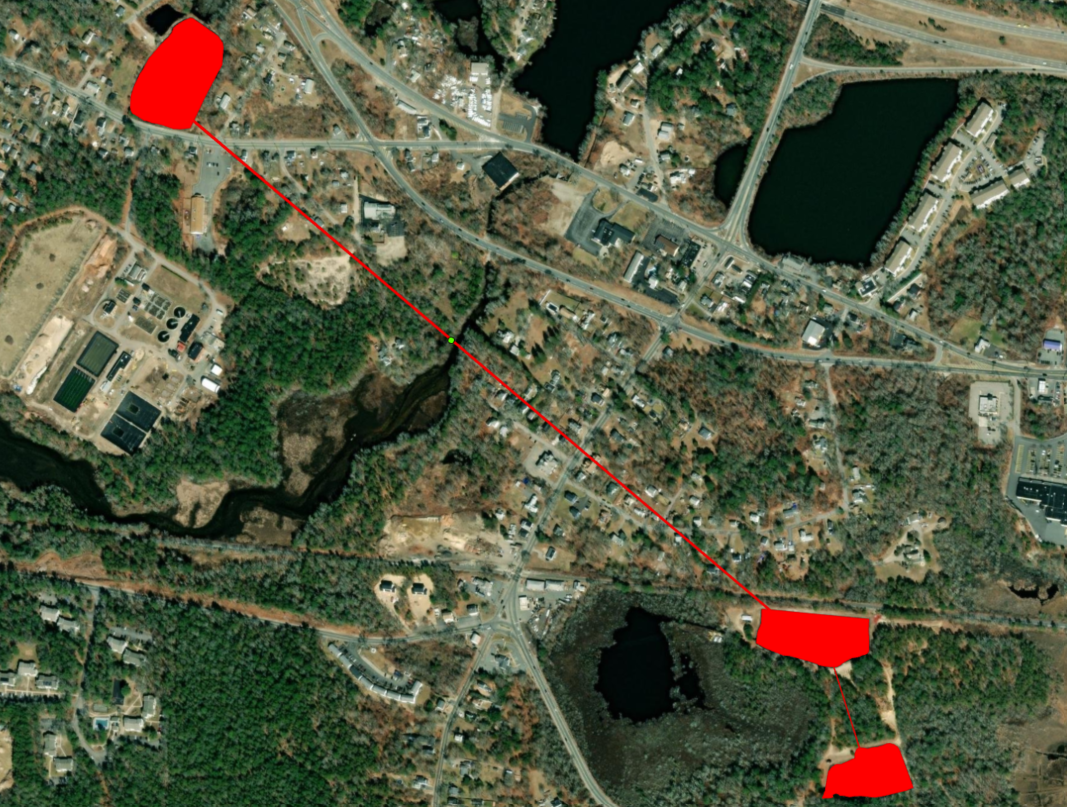

In [18]:
# Negative buffer around perimeter to remove small corridors (this removes links bewteen bogs with the same permit that are not hydrologically connected)
buff_dist = 3
bogs_neg = "bogs_buff_neg{}m".format(buff_dist)
arcpy.analysis.PairwiseBuffer(
    in_features=bogs_raw,
    out_feature_class=bogs_neg,
    buffer_distance_or_field="-{} Meters".format(buff_dist),
    dissolve_option="NONE",
    dissolve_field=None,
    method="PLANAR",
    max_deviation="0 Meters"
)

<Result 'C:\\Workspace\\Geodata\\Cran_Q_C\\Default.gdb\\bogs_buff_neg3m'>

In [19]:
# positive buffer to return to original area
bogs_neg_pos = bogs_neg+"_pos{}m".format(buff_dist)
arcpy.analysis.PairwiseBuffer(
    in_features=bogs_neg,
    out_feature_class=bogs_neg_pos,
    buffer_distance_or_field="{} Meters".format(buff_dist),
    dissolve_option="NONE",
    dissolve_field=None,
    method="PLANAR",
    max_deviation="0 Meters"
)

<Result 'C:\\Workspace\\Geodata\\Cran_Q_C\\Default.gdb\\bogs_buff_neg3m_pos3m'>

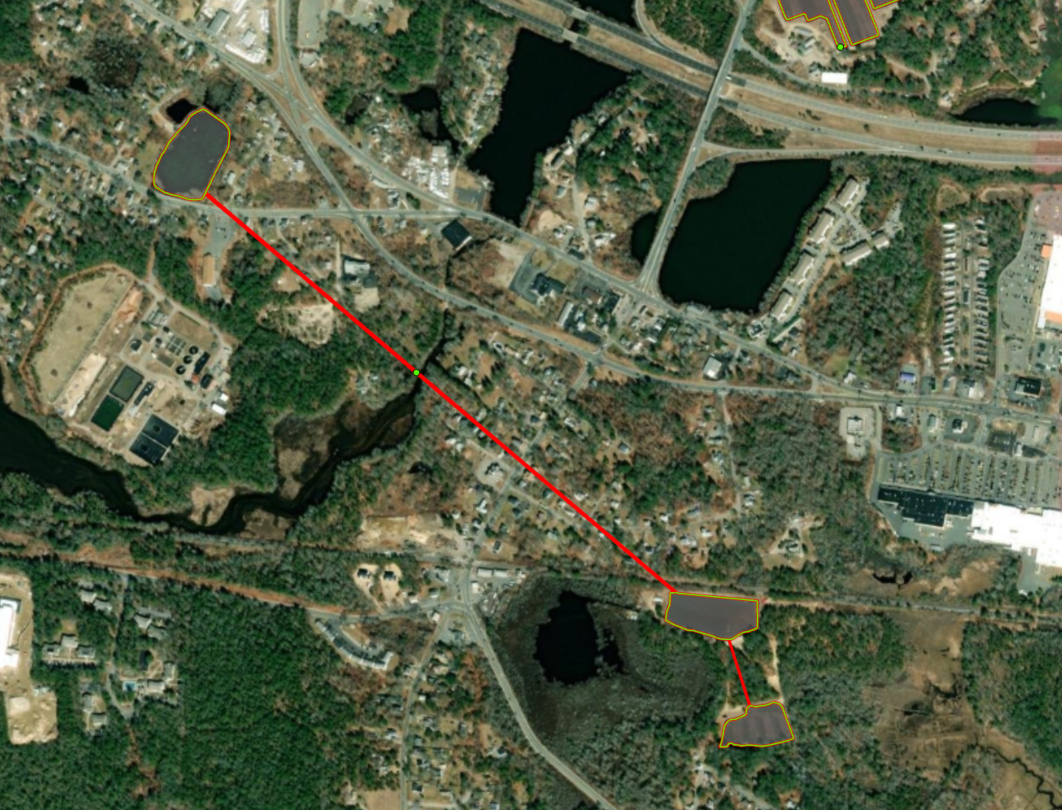

In [20]:
# split all features containing multipart polygons (unconnected) into single part features (one feature per polygon). 
bogs_split = bogs_neg_pos+"_split"
arcpy.management.MultipartToSinglepart(bogs_neg_pos, bogs_split)

<Result 'C:\\Workspace\\Geodata\\Cran_Q_C\\Default.gdb\\bogs_buff_neg3m_pos3m_split'>

In [21]:
# aggregate polygons of bogs within 20 meters and sharing the same FID. 
# note that this modifies the shape of polygons by creating new corridors that link between adjacent polygons
# this increases total area to the of all polygons in the layer (which can lead to overestimates of potentially restorable bog area). 
agg_dist = 30 # meters
bogs_agg = "bogs_agg"
arcpy.cartography.AggregatePolygons(
    in_features=bogs_split,
    out_feature_class=bogs_agg,
    aggregation_distance="{} Meters".format(agg_dist),
    minimum_area=None,
    minimum_hole_size="0 SquareMeters",
    orthogonality_option="NON_ORTHOGONAL",
    barrier_features=None,
    out_table="{}_Tbl".format(bogs_agg),
    aggregate_field="ORIG_FID"
)

<Result 'C:\\Workspace\\Geodata\\Cran_Q_C\\Default.gdb\\bogs_agg'>

In [22]:
# use identity to get FID of aggregated bogs 
bogs_ident = "bogs_ident"
arcpy.analysis.Identity(
    in_features=bogs_split,
    identity_features=bogs_agg,
    out_feature_class=bogs_ident,
    join_attributes="ONLY_FID",
    cluster_tolerance=None,
    relationship="NO_RELATIONSHIPS"
)

<Result 'C:\\Workspace\\Geodata\\Cran_Q_C\\Default.gdb\\bogs_ident'>

In [23]:
# dissolve all features with that have the same value for FID of bog_agg
# this groups feature within 20m but without adding area 
bogs_ident_diss = "bogs_ident_dissolved"
arcpy.management.Dissolve(
    in_features=bogs_ident,
    out_feature_class=bogs_ident_diss,
    dissolve_field="FID_{}".format(bogs_agg),
    statistics_fields=None,
    multi_part="MULTI_PART",
    unsplit_lines="DISSOLVE_LINES",
    concatenation_separator=""
)

<Result 'C:\\Workspace\\Geodata\\Cran_Q_C\\Default.gdb\\bogs_ident_dissolved'>

In [24]:
# use identity to get original raw bog FIDs
bogs_ident_diss = "bogs_ident_dissolved"
bogs_raw = "bogs_raw"
bogs_agg_diss_ident = "bogs_agg_diss_ident"
arcpy.analysis.Identity(
    in_features=bogs_ident_diss,
    identity_features=bogs_raw,
    out_feature_class=bogs_agg_diss_ident,
    #join_attributes="ONLY_FID",
    cluster_tolerance=None,
    relationship="NO_RELATIONSHIPS")

<Result 'C:\\Workspace\\Geodata\\Cran_Q_C\\Default.gdb\\bogs_agg_diss_ident'>

In [25]:
# Remove unwanted artifacts of preprocessing. 


# select and delete any polygons that do not overlap with original bogs 
# these areas are noted by FID_bogs_raw = -1
bogs_agg_diss_ident = "bogs_agg_diss_ident"
arcpy.management.SelectLayerByAttribute(
    in_layer_or_view=bogs_agg_diss_ident,
    selection_type="NEW_SELECTION",
    where_clause="FID_bogs_raw = -1",
    invert_where_clause=None)

<Result 'bogs_agg_diss_ident_Layer1'>

In [26]:
arcpy.management.DeleteRows(
    in_rows=bogs_agg_diss_ident)

<Result 'C:\\Workspace\\Geodata\\Cran_Q_C\\Default.gdb\\bogs_agg_diss_ident'>

In [27]:
bogs_agg_diss_ident = "bogs_agg_diss_ident"
arcpy.management.SelectLayerByAttribute(
    in_layer_or_view=bogs_agg_diss_ident,
    selection_type="CLEAR_SELECTION")

# remove rows where area is <100m
arcpy.management.SelectLayerByAttribute(
    in_layer_or_view=bogs_agg_diss_ident,
    selection_type="NEW_SELECTION",
    where_clause="Shape_Area < 100")

<Result 'bogs_agg_diss_ident_Layer3'>

In [28]:
arcpy.management.DeleteRows(in_rows=bogs_agg_diss_ident)

<Result 'C:\\Workspace\\Geodata\\Cran_Q_C\\Default.gdb\\bogs_agg_diss_ident'>